# Imports

In [39]:
# Standard library imports
import os
import json
import random
import warnings

# Data processing and numerical operations
import pandas as pd
import numpy as np

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable
%matplotlib inline

# Deep learning frameworks
import torch as pt

import kagglehub
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image

# Progress bar
from tqdm import tqdm

# Configure plotting
plt.style.use('fivethirtyeight')
sns.set_theme(style='whitegrid', palette='deep')

# Suppress warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Data Loading

## Dataset
Unsupervised Labeled Lane Markers (LLAMAS) Dataset is a computer vision dataset focused on lane detection and lane marker annotation. The dataset contains over 100,000 annotated images of road scenes with lane markers, designed to support unsupervised learning approaches in autonomous driving and road scene understanding.
LLAMAS provides a comprehensive collection of road scene images with high-resolution imagery at 1276 x 717 pixels, capturing lane markers with annotations extending over 100 meters. The dataset enables machine learning models to learn lane detection and lane marker segmentation without extensive manual labeling, leveraging advanced unsupervised learning techniques.
The dataset includes a wide range of lane marker variations, such as solid lines, dashed lines, double lines, and complex lane configurations, making it a robust resource for developing and testing lane detection algorithms in autonomous vehicle systems. With its extensive collection of over 100,000 annotated images, LLAMAS offers researchers and developers a rich, detailed dataset for advancing autonomous driving technologies.

Dataset structure
```json
{
    'grayscale_images': {
        'test': {'images-*',},
        'valid': {'images-*',},
        'train': {
            'images-*',
        }
    },
    'labels': {
        'labels': {
            'train': {'images-*',},
            'valid': {'images-*',}
        }
    }
}
```




In [2]:
dataset = kagglehub.dataset_download('vidityagi/llamas-grayscale')

100%|██████████| 34.0G/34.0G [07:45<00:00, 78.5MB/s]


Extracting files...


In [27]:
def get_dataset_info(dataset_path):
    image_files = []
    label_files = []

    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.png'):
                image_files.append(os.path.join(root, file))
            elif file.endswith('.json'):
                label_files.append(os.path.join(root, file))

    # basic dataset info
    dataset_info = {
        'total_files': len(image_files) + len(label_files),
        'total_images': len(image_files),
        'total_labels': len(label_files),
    }

    # image dimension
    image_dims = []
    for img_path in image_files[:100]:
        with Image.open(img_path) as img:
            image_dims.append(img.size)
    unique_dims = set(image_dims)
    dataset_info['unique_image_dimensions'] = list(unique_dims)

    return dataset_info, image_files


dataset_info, image_files = get_dataset_info(dataset)
for key, value in dataset_info.items():
    print(f"{key}: {value}")

total_files: 179155
total_images: 100042
total_labels: 79113
unique_image_dimensions: [(1276, 717)]


# EDA

In [28]:
# image dimensions
print("Image Dimensions:")
unique_dims = dataset_info['unique_image_dimensions']
for dim in unique_dims:
    print(f"  height {dim[0]} x width {dim[1]}")

Image Dimensions:
  height 1276 x width 717


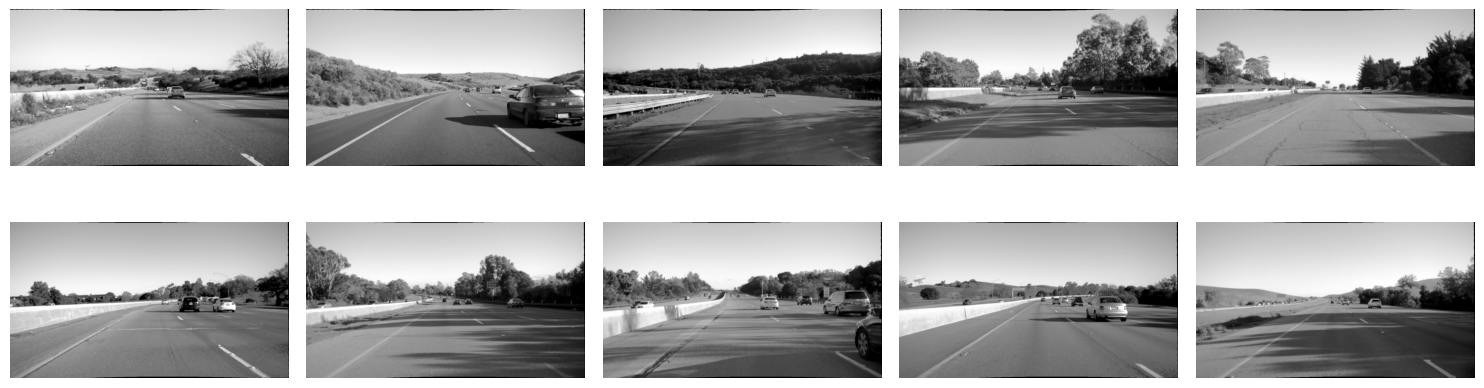

In [36]:
# sample images visualization
plt.figure(figsize=(15, 5))
for i, img_path in enumerate(image_files[:10]):
    img = Image.open(img_path)
    plt.subplot(2, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [37]:
# pixel value statistics
pixel_values = []
for img_path in image_files[:10]:
    img = np.array(Image.open(img_path))
    pixel_values.extend(img.flatten())

pixel_values = np.array(pixel_values)
print("Pixel Value Statistics:")
print(f"  Min Pixel Value: {pixel_values.min()}")
print(f"  Max Pixel Value: {pixel_values.max()}")
print(f"  Mean Pixel Value: {pixel_values.mean():.2f}")
print(f"  Median Pixel Value: {np.median(pixel_values):.2f}")
print(f"  Standard Deviation of Pixel Values: {pixel_values.std():.2f}")

Pixel Value Statistics:
  Min Pixel Value: 0
  Max Pixel Value: 255
  Mean Pixel Value: 142.40
  Median Pixel Value: 141.00
  Standard Deviation of Pixel Values: 67.38


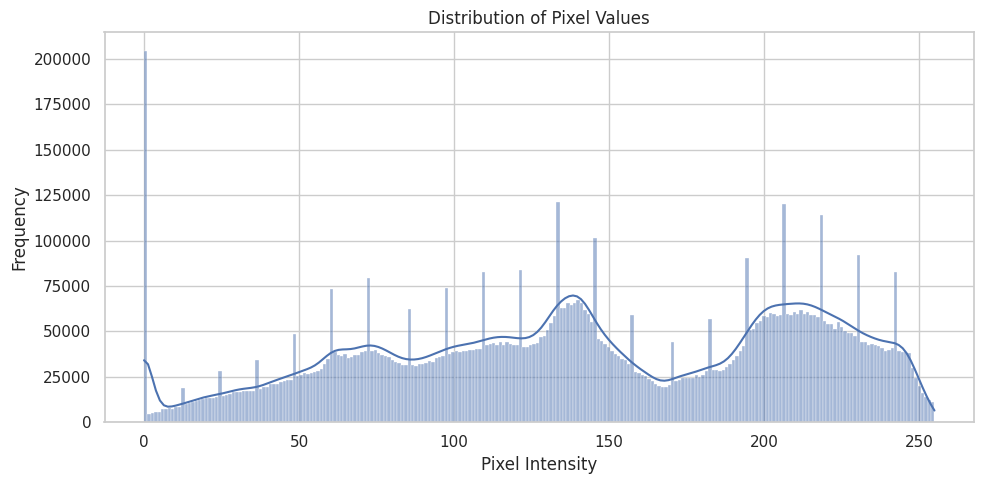

In [32]:
# pixel value distribution
plt.figure(figsize=(10, 5))
sns.histplot(pixel_values, kde=True)
plt.title('Distribution of Pixel Values')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Pre-Processing

In [ ]:
def preprocess_grayscale_images_opencv(image_files, target_size=(128, 128), normalize=True):
    preprocessed_images = []
    for img_path in image_files:
        # read the image in grayscale mode
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Warning: Unable to read image {img_path}. Skipping.")
            continue
        # resize image
        img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
        # normalize image
        if normalize:
            img = img.astype(np.float32) / 255.0
        preprocessed_images.append(img)

    return np.array(preprocessed_images)

preprocessed_images = preprocess_grayscale_images_opencv(image_files, target_size=(128, 128))
print(f"Shape of preprocessed images array: {preprocessed_images.shape}")